In [13]:
import zarrtraj
import MDAnalysis as mda
import zarr
from zarr.storage import LRUStoreCache
import s3fs
import os

# 1
yiipHDD = zarr.open_group("notebook_data_tmp/yiip.zarrtraj", mode='r')

# 2
# Use your own bucket here

s3_fs = s3fs.S3FileSystem(
    # anon must be false to allow authentication
    anon=False,
    # use profiles defined in a .aws/credentials file to store secret keys
    # docs: 
    profile='sample_profile',
    client_kwargs=dict(
        region_name='us-west-1',
    )
)
store = s3fs.S3Map(root=f'zarrtraj-test-data/yiip.zarrtraj',
                  s3=s3_fs,
                  check=False)
# Select max_size value in bytes based on chunking of zarrtraj data
# At least one chunk must fit in the cache
cache = LRUStoreCache(store, max_size=10485760)
yiipS3 = zarr.open_group(store=cache, mode='r')

# 3
uHDD = mda.Universe("notebook_data_tmp/yiip_equilibrium/YiiP_system.pdb", yiipHDD)
uS3 = mda.Universe("notebook_data_tmp/yiip_equilibrium/YiiP_system.pdb", yiipS3)
uXTC = mda.Universe("notebook_data_tmp/yiip_equilibrium/YiiP_system.pdb", "notebook_data_tmp/yiip.xtc")

/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element Z found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element D found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to gu

In [14]:
import MDAnalysis as mda
import MDAnalysis.analysis.pca as pca
import time
import json

# 4

universes = dict()
universes["uHDD"] = dict()
universes["uHDD"]["ref"] = uHDD
universes["uS3"] = dict()
universes["uS3"]["ref"] = uS3
universes["uXTC"] = dict()
universes["uXTC"]["ref"] = uXTC


for name in ("uHDD", "uS3", "uXTC"):
    start = time.time()
    PSF_pca = pca.PCA(universes[name]["ref"], select='backbone')
    PSF_pca.run()
    stop = time.time()
    universes[name]["PCA"] = stop - start

pca_speeds = dict()
pca_speeds["uXTC"] = universes["uXTC"]["PCA"]
pca_speeds["uS3"] = universes["uS3"]["PCA"]
pca_speeds["uHDD"] = universes["uHDD"]["PCA"]
with open('notebook_data_tmp/pca_speeds.json', 'w') as j:
    json.dump(pca_speeds, j)

/nfs/homes3/ljwoods2/.conda/envs/zarrtraj/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


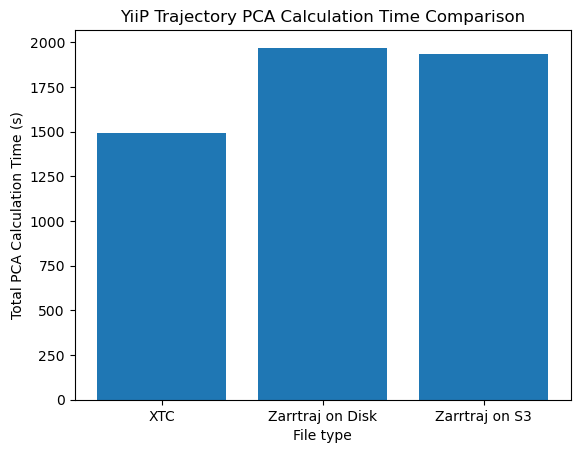

In [1]:
import matplotlib.pyplot as plt
import json

# 5. Graph performance.

with open('notebook_data_tmp/pca_speeds.json', 'r') as j:
    data = json.load(j)

time_vals = [data["uXTC"], data["uHDD"], data["uS3"]]
filenames = ["XTC", "Zarrtraj on Disk", "Zarrtraj on S3"]

plt.bar(filenames, time_vals)
plt.title('YiiP Trajectory PCA Calculation Time Comparison')
plt.xlabel('File type')
plt.ylabel('Total PCA Calculation Time (s)')

plt.savefig("pca_speeds.svg", format='svg')
plt.show()